[[이유한님] 캐글 코리아 캐글 스터디 커널 커리큘럼](https://kaggle-kr.tistory.com/32)

[Statoil/C-CORE Iceberg Classifier Challenge](https://www.kaggle.com/c/statoil-iceberg-classifier-challenge)

[Keras+TF LB 0.18](https://www.kaggle.com/code/wvadim/keras-tf-lb-0-18)

**Introduction** This is actually my first public kernel, so i hope it will be useful for someone.

Before you read the notebook, it is immportant to know that this notebook is a compilation of already existing notebooks and some model modifications Here is list of notebooks:

- Data analysis - https://www.kaggle.com/muonneutrino/exploration-transforming-images-in-python
- Image conversion, Network architecture - https://www.kaggle.com/tivigovidiu/keras-model-for-beginners-0-210-on-lb-eda-r-d
- Some ideas - https://www.kaggle.com/knowledgegrappler/a-keras-prototype-0-21174-on-pl
- Code for conversion to image provided by MadScientist but i don't know which kernel it is.

Before running the model it is good idea to run thgrough kernels mentioned here and upvote them.

**Comments** I've executed this code on my machine with 1080 TI and it may be pretty slow if you have low-end GPU or CPU

It is also important that i don't know how to execute code in the notebook with GPU, since keras is not freeing memory after model training, so train results here may be uncomplete.

I am also not sure about random seed initialization and haven't checked it, so maybe your results may differ from mine.

I am also sorry for a WinAPI style functions with 10+ arguments, but this solutin was made less than in a one day and basically my second solution. If someone is able to rewrite it in a normal style i will appreciate that, so feel free to fork and rewrite.

**DeepL 번역**  
**소개** 사실 제가 처음으로 공개하는 커널이기 때문에 누군가에게 도움이 되길 바랍니다.

노트북을 읽기 전에 이 노트북은 이미 존재하는 노트북을 편집하고 일부 모델을 수정한 것임을 알아두는 것이 중요합니다. 다음은 노트북 목록입니다:

- 데이터 분석 - https://www.kaggle.com/muonneutrino/exploration-transforming-images-in-python
- 이미지 변환, 네트워크 아키텍처 - https://www.kaggle.com/tivigovidiu/keras-model-for-beginners-0-210-on-lb-eda-r-d
- 몇 가지 아이디어 - https://www.kaggle.com/knowledgegrappler/a-keras-prototype-0-21174-on-pl
- MadScientist에서 이미지로 변환하는 코드를 제공했지만 어떤 커널인지 모르겠습니다.

모델을 실행하기 전에 여기에 언급 된 커널을 실행하고 업보트하는 것이 좋습니다.

**첨언** 1080 TI가 장착 된 컴퓨터에서이 코드를 실행했으며 저사양 GPU 또는 CPU가있는 경우 상당히 느릴 수 있습니다.

또한 모델 훈련 후 케라스가 메모리를 해제하지 않기 때문에 GPU가있는 노트북에서 코드를 실행하는 방법을 모르기 때문에 여기서 훈련 결과가 불완전 할 수 있습니다.

또한 무작위 시드 초기화에 대해 잘 모르겠고 확인하지 않았으므로 결과가 저와 다를 수 있습니다.

또한 10 개 이상의 인수가있는 WinAPI 스타일 함수에 대해 죄송하지만이 솔루션은 하루도 채 걸리지 않고 기본적으로 두 번째 솔루션입니다. 누군가가 정상적인 스타일로 다시 작성할 수 있다면 감사 할 것이므로 자유롭게 포크하고 다시 작성하십시오.

Translated with DeepL.com (free version)

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Random initialization
import numpy as np
np.random.seed(98643)
import tensorflow as tf
# tf.set_random_seed(683)
tf.random.set_seed(683) # 함수 변경
# Uncomment this to hide TF warnings about allocation
# import os
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# An image clearing dependencies
from skimage.restoration import (denoise_tv_chambolle, denoise_bilateral, denoise_wavelet, estimate_sigma, denoise_tv_bregman, denoise_nl_means)
# denoise_tv_chambolle: 총 변동(Total Variation) 기반 필터로 이미지 노이즈 제거
# denoise_bilateral:    양방향 필터링(Bilateral Filtering)으로 이미지의 엣지 보존 노이즈 제거
# denoise_wavelet:      웨이블릿 변환(Wavelet Denoising)으로 노이즈 제거
# estimate_sigma:       노이즈 표준편차 추정
# denoise_tv_bregman:   Bregman 총 변동 기반 노이즈 제거법. 이미지 윤관 유지하며 노이즈 제거
# denoise_nl_means:     비국소적 평균(Non-Local Means) 필터는 유사 패턴 픽셀들의 가중 평균으로 대체하여 노이즈 제거

from skimage.filters import gaussian    # 이미지를 부드럽게 만들거나 블러 적용
from skimage.color import rgb2gray

# Data reading and visualization
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler

# Training part
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, GlobalAveragePooling2D, Lambda
from keras.layers import GlobalMaxPooling2D
# from keras.layers.normalization import BatchNormalization
# from keras.layers.merge import Concatenate
from keras.layers import BatchNormalization, Concatenate    # 버전 차이
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
# from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator # tf에서 호출해야지만 import 됨

# Any results you write to the current directory are saved as output.

2025-01-21 16:46:58.413671: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-21 16:46:58.428058: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-21 16:46:58.428087: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-21 16:46:58.438012: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-21 16:46:58.980132: W tensorflow/compiler/tf

First of all, some data preprocessing is required.

The basic idea is that images, that provided in a dataset are very noisy and if we will get rid of granular noise, we will be able to predict better and construct noisy dataset by our own.

It is also interesting to train a denoising autoencoder on dataset in order to extract some global features that may be used further on model training.

**DeepL 번역**  
우선, 약간의 데이터 전처리가 필요합니다.

기본 아이디어는 데이터 세트에서 제공되는 이미지에는 노이즈가 매우 많기 때문에 세분화된 노이즈를 제거하면 더 나은 예측이 가능하고 노이즈가 적은 데이터 세트를 자체적으로 구성할 수 있다는 것입니다.

모델 훈련에 추가로 사용할 수 있는 글로벌 특징을 추출하기 위해 데이터 세트에서 노이즈 제거 자동 인코더를 훈련하는 것도 흥미롭습니다.

In [3]:
# Translate data to an image format
def color_composite(data):
    rgb_arrays = []
    for i, row in data.iterrows():
        band_1 = np.array(row['band_1']).reshape(75, 75)
        band_2 = np.array(row['band_2']).reshape(75, 75)
        band_3 = band_1 / band_2

        r = (band_1 + abs(band_1.min())) / np.max((band_1 + abs(band_1.min())))
        
        g = (band_2 + abs(band_2.min())) / np.max((band_2 + abs(band_2.min())))

        b = (band_3 + abs(band_3.min())) / np.max((band_3 + abs(band_3.min())))

        rgb = np.dstack((r, g, b))
        rgb_arrays.append(rgb)
    
    return np.array(rgb_arrays)

def denoise(X, weight, multichannel):
    # return np.asarray([denoise_tv_chambolle(item, weight=weight, multichannel=multichannel) for item in X])
    return np.asarray([denoise_tv_chambolle(item, weight=weight, channel_axis=multichannel) for item in X]) # 인자명 변경된 듯

def smooth(X, sigma):
    return np.asarray([gaussian(item, sigma=sigma) for item in X])

def grayscale(X):
    return np.asarray([rgb2gray(item) for item in X])

In [4]:
train = pd.read_json("./input/005_statoil-iceberg-classifier-challenge/train.json")
train.inc_angle = train.inc_angle.replace('na', 0)
train.inc_angle = train.inc_angle.astype(float).fillna(0.0)
train_all = True

# These are train flags that required to train model more efficiently and
# select proper model parameters
train_b = True or train_all
train_img = True or train_all
train_total = True or train_all
predict_submission = True or train_all

clean_all = False
clean_b = False or clean_all
clean_img = False or clean_all

load_all = False
load_b = False or load_all
load_img = False or load_all

In [5]:
def create_dataset(frame, labeled, smooth_rgb=0.2, smooth_gray=0.5,
                   weight_rgb=0.05, weight_gray=0.05):
    band_1, band_2, images = frame['band_1'].values, frame['band_2'].values, color_composite(frame)
    to_arr = lambda x: np.asarray([np.asarray(item) for item in x])
    band_1 = to_arr(band_1)
    band_2 = to_arr(band_2)
    band_3 = (band_1 + band_2) / 2
    gray_reshape = lambda x: np.asarray([item.reshape(75, 75) for item in x])
    # Make a picture format from flat vector
    band_1 = gray_reshape(band_1)
    band_2 = gray_reshape(band_2)
    band_3 = gray_reshape(band_3)
    print('Denoising and reshaping')
    if train_b and clean_b:
        # Smooth and denoise data
        band_1 = smooth(denoise(band_1, weight_gray, False), smooth_gray)
        print('Gray 1 done')
        band_2 = smooth(denoise(band_2, weight_gray, False), smooth_gray)
        print('Gray 2 done')
        band_3 = smooth(denoise(band_3, weight_gray, False), smooth_gray)
        print('Gray 3 done')
    if train_img and clean_img:
        images = smooth(denoise(images, weight_rgb, True), smooth_rgb)
    print('RGB done')
    tf_reshape = lambda x: np.asarray([item.reshape(75, 75, 1) for item in x])
    band_1 = tf_reshape(band_1)
    band_2 = tf_reshape(band_2)
    band_3 = tf_reshape(band_3)
    # images = tf_reshape(images)
    band = np.concatenate([band_1, band_2, band_3], axis=3)
    if labeled:
        y = np.array(frame["is_iceberg"])
    else:
        y = None
    
    return y, band, images

In [6]:
y_train, X_b, X_images = create_dataset(train, True)

Denoising and reshaping
RGB done


Plotting some random images to check how cleaning works

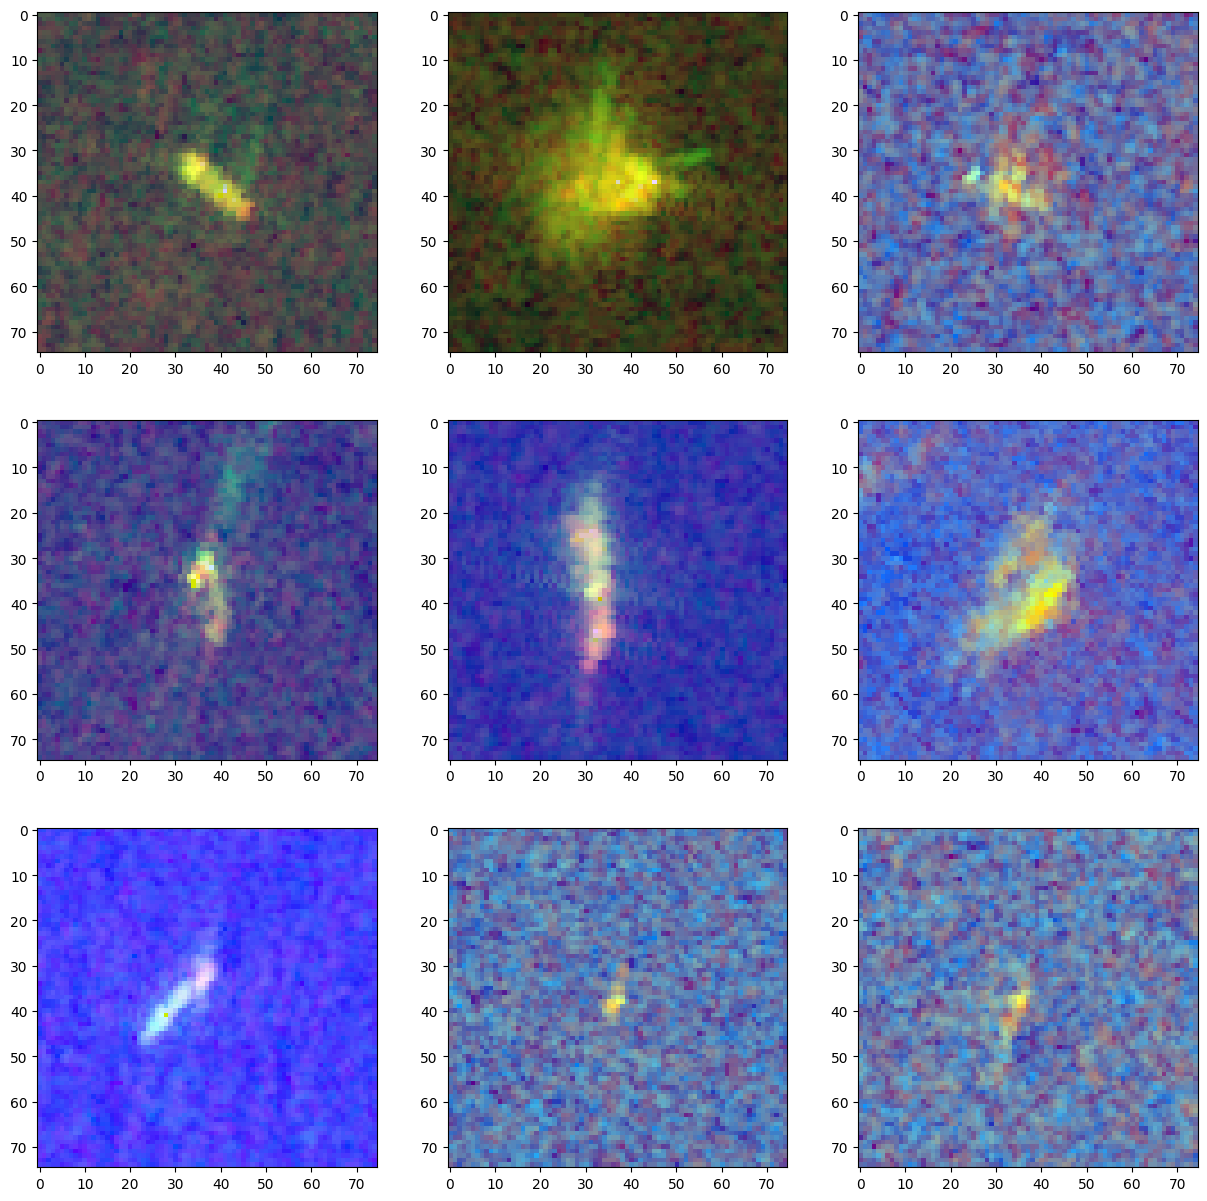

In [7]:
fig = plt.figure(200, figsize=(15, 15))
random_indicies = np.random.choice(range(len(X_images)), 9, False)
subset = X_images[random_indicies]
for i in range(9):
    ax = fig.add_subplot(3, 3, i + 1)
    ax.imshow(subset[i])
plt.show()

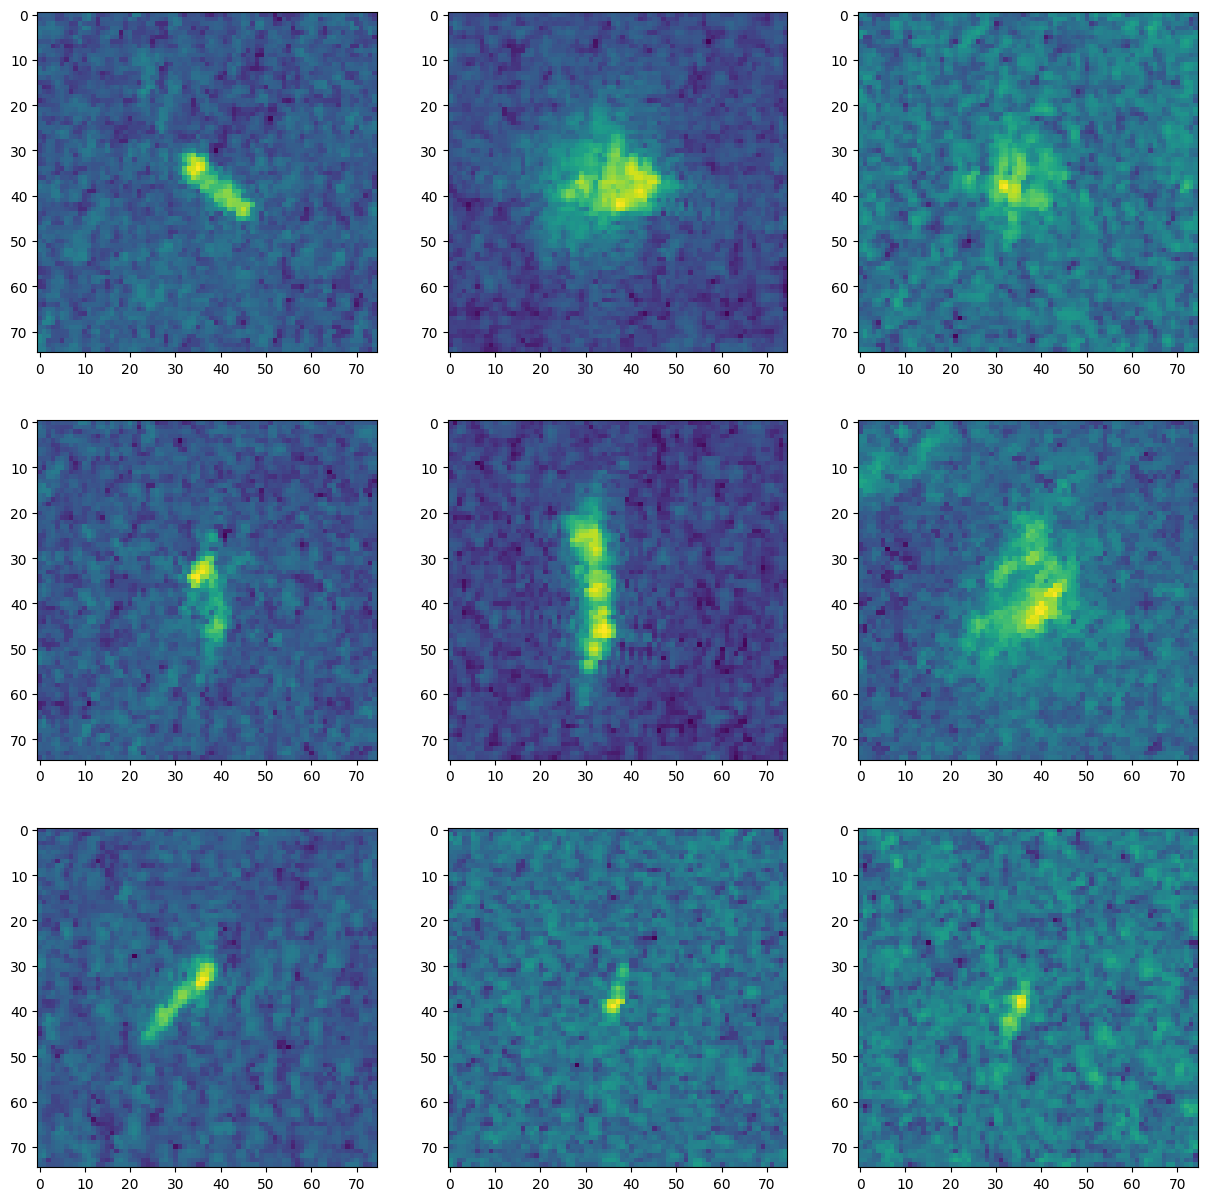

In [8]:
fig = plt.figure(202, figsize=(15, 15))
band_1_x = train['band_1'].values
subset = np.asarray(band_1_x)[random_indicies]
subset = np.asarray([np.asarray(item).reshape(75, 75) for item in subset])
for i in range(9):
    ax = fig.add_subplot(3, 3, i + 1)
    ax.imshow(subset[i])
plt.show()

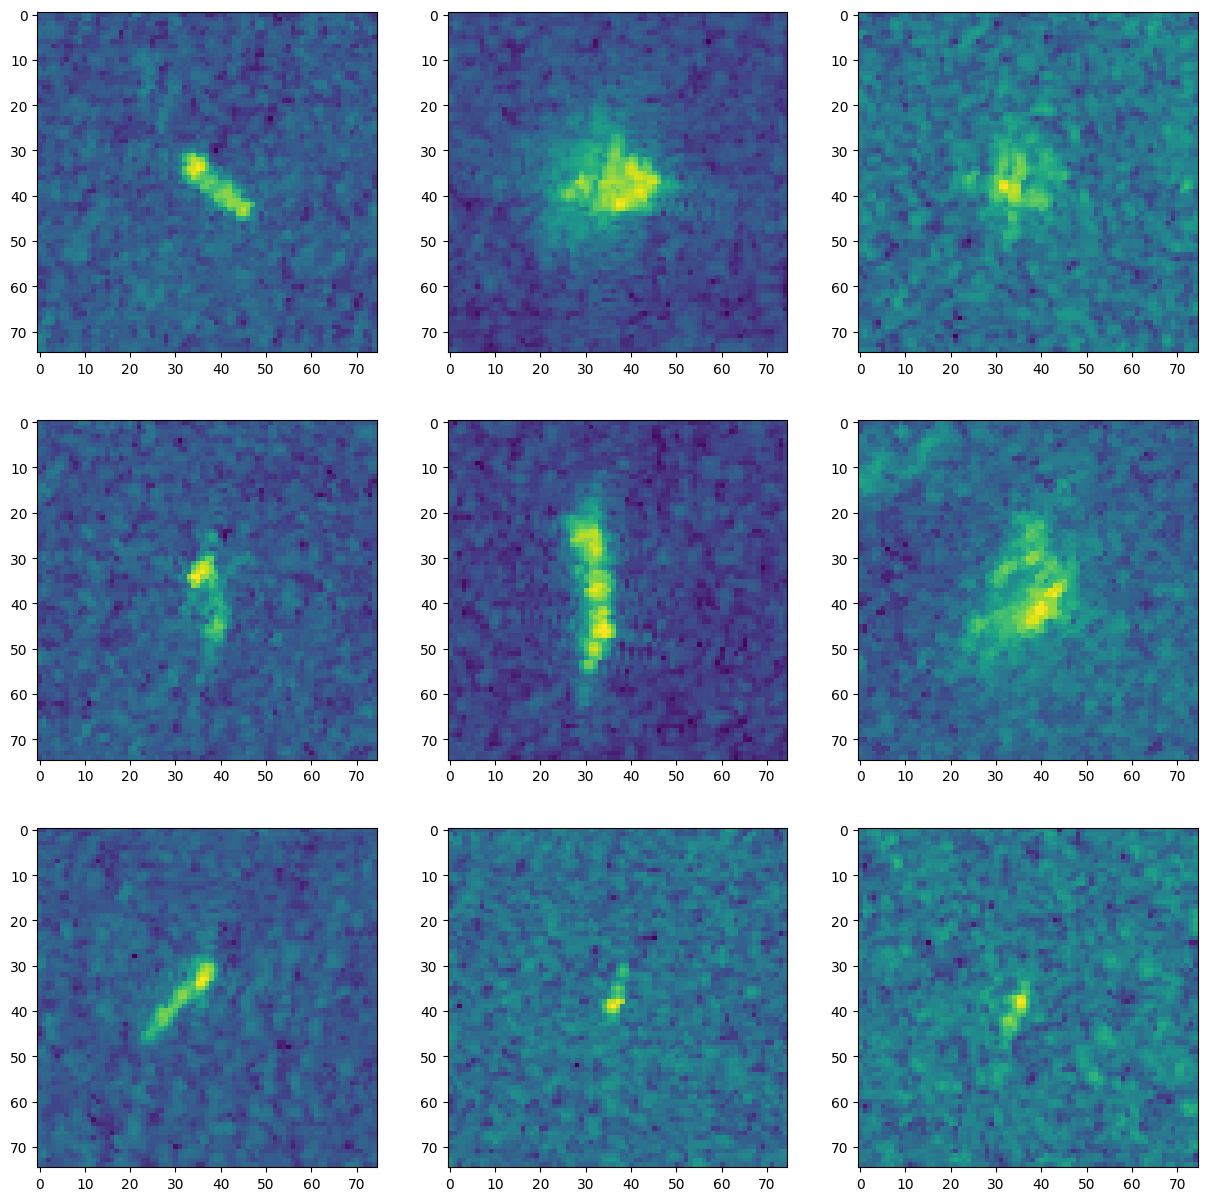

In [9]:
fig = plt.figure(202, figsize=(15, 15))
subset = np.asarray(band_1_x)[random_indicies]
subset = denoise(np.asarray([np.asarray(item).reshape(75, 75) for item in subset]), 0.05, False)
for i in range(9):
    ax = fig.add_subplot(3, 3, i + 1)
    ax.imshow(subset[i])
plt.show()

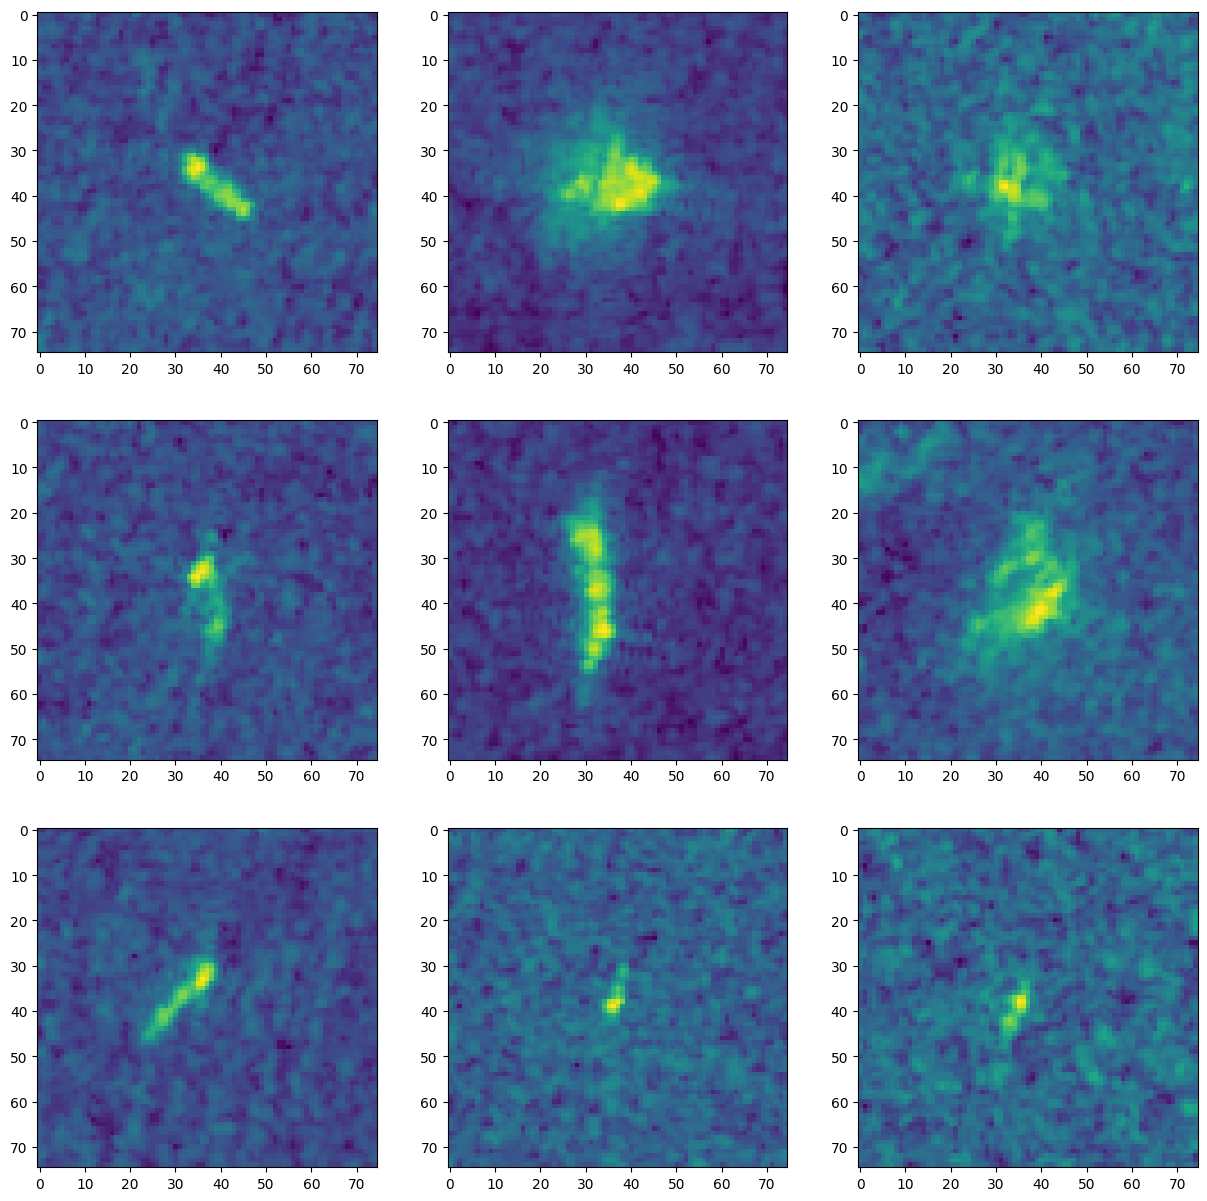

In [10]:
fig = plt.figure(202, figsize=(15, 15))
subset = np.asarray(band_1_x)[random_indicies]
subset = smooth(denoise(np.asarray(
    [np.asarray(item).reshape(75, 75) for item in subset]), 0.05, False), 0.5)
for i in range(9):
    ax = fig.add_subplot(3, 3, i + 1)
    ax.imshow(subset[i])
plt.show()

**A few words about model**

The model itself consists of 3 convolutional neural networks. Two basic networks and one combined. The idea is to train two basic networks on different data representations and after that, using trained convolutional layers in combination to train common network.

Architecture for these networks is taken from notebook mentioned in the vere beginning.

For training i'm using 3 datasets, 1 that network sees only once and default keras val split for model selection.

**DeepL 번역**  

모델 자체는 3개의 컨볼루션 신경망으로 구성됩니다. 두 개의 기본 네트워크와 하나의 결합 네트워크. 서로 다른 데이터 표현에 대해 두 개의 기본 네트워크를 훈련한 다음, 훈련된 컨볼루션 레이어를 조합하여 공통 네트워크를 훈련하는 것이 아이디어입니다.

이러한 네트워크의 아키텍처는 앞부분에서 언급한 노트북에서 가져왔습니다.

훈련에는 3개의 데이터 세트, 네트워크가 한 번만 보는 데이터 세트, 모델 선택을 위한 기본 케라스 값 분할을 사용하고 있습니다.

In [11]:
def get_model_notebook(lr, decay, channels, relu_type='reklu'):
    # angle variable defines if we should use angle parameter or ignore it
    input_1 = Input(shape=(75, 75, channels))

    fcnn = Conv2D(32, kernel_size=(3, 3), activation=relu_type)(
        BatchNormalization()(input_1))
    fcnn = MaxPooling2D((3, 3))(fcnn)
    fcnn = Dropout(0.2)(fcnn)
    fcnn = Conv2D(64, kernel_size=(3, 3), activation=relu_type)(fcnn)
    fcnn = MaxPooling2D((2, 2), strides=(2, 2))(fcnn)
    fcnn = Dropout(0.2)(fcnn)
    fcnn = Conv2D(128, kernel_size=(3, 3), activation=relu_type)(fcnn)
    fcnn = MaxPooling2D((2, 2), strides=(2, 2))(fcnn)
    fcnn = Dropout(0.2)(fcnn)
    fcnn = Conv2D(128, kernel_size=(3, 3), activation=relu_type)(fcnn)
    fcnn = MaxPooling2D((2, 2), strides=(2, 2))(fcnn)
    fcnn = Dropout(0.2)(fcnn)
    fcnn = BatchNormalization()(fcnn)
    fcnn = Flatten()(fcnn)
    local_input = input_1
    partial_model = Model(input_1, fcnn)
    dense = Dropout(0.2)(fcnn)
    dense = Dense(256, activation=relu_type)(dense)
    dense = Dropout(0.2)(dense)
    dense = Dense(128, activation=relu_type)(dense)
    dense = Dropout(0.2)(dense)
    dense = Dense(64, activation=relu_type)(dense)
    dense = Dropout(0.2)(dense)
    # For some reason I've decided not to normaliuze angle data
    output = Dense(1, activation="sigmoid")(dense)
    model = Model(local_input, output)
    # optimizer = Adam(lr=lr, decay=decay)    # 인자명 변경됨.
    optimizer = Adam(learning_rate=lr, decay=decay)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=["accuracy"])

    return model, partial_model

In [12]:
def combined_model(m_b, m_img, lr, decay):
    input_b = Input(shape=(75, 75, 3))
    input_img = Input(shape=(75, 75, 3))

    # I've never tested non-trainable source models tho
    # for layer in m_b.layers:
    #     layer.trainable = False
    # for layer in m_img.layers:
    #     layer.trainable = False

    m1 = m_b(input_b)
    m2 = m_img(input_img)

    # So, combine models and train perceptron based on that
    # The iteresting idea is to use XGB for this task, but i actually hate this method
    common = Concatenate()([m1, m2])
    common = BatchNormalization()(common)
    common = Dropout(0.3)(common)
    common = Dense(1024, activation='relu')(common)
    common = Dropout(0.3)(common)
    common = Dense(512, activation='relu')(common)
    common = Dropout(0.3)(common)
    output = Dense(1, activation='sigmoid')(common)
    model = Model([input_b, input_img], output)
    # optimizer = Adam(lr=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=decay)   # 인자명 변경
    optimizer = Adam(learning_rate=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=decay)
    model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

    return model

In [13]:
def gen_flow_multi_inputs(I1, I2, y, batch_size):
    gen1 = ImageDataGenerator(horizontal_flip=True,
                              vertical_flip=True,
                              width_shift_range=0.,
                              height_shift_range=0.,
                              channel_shift_range=0.,
                              zoom_range=0.2,
                              rotation_range=10)
    gen2 = ImageDataGenerator(horizontal_flip=True,
                              vertical_flip=True,
                              width_shift_range=0.,
                              height_shift_range=0.,
                              channel_shift_range=0.,
                              zoom_range=0.2,
                              rotation_range=10)
    genI1 = gen1.flow(I1, y, batch_size=batch_size, seed=57, shuffle=False)
    genI2 = gen2.flow(I1, I2, batch_size=batch_size, seed=57, shuffle=False)
    while True:
        # I1i = genI1.next()
        # I2i = genI2.next()
        # next -> __next__
        I1i = genI1.__next__()
        I2i = genI2.__next__()
        # print(I1i[0].shape)
        np.testing.assert_array_equal(I2i[0], I1i[0])
        # yield [I1i[0], I2i[1], I1i[1]]
        # 오류문: ValueError: When passing a Python generator to a Keras model, the generator must return a tuple, either (input,) or (inputs, targets) or (inputs, targets, sample_weights).
        yield ((I1i[0], I2i[1]), I1i[1])  # 튜플로 반환해야만 함. 튜플로 X 묶음(리스트로 묶으면 자료형 오류 발생)

In [14]:
def train_model(model, batch_size, epochs, checkpoint_name, X_train, y_train, val_data, verbose=2):
    # callbacks = [ModelCheckpoint(checkpoint_name, save_best_only=True, monitor='val_loss')]
    callbacks = [ModelCheckpoint(checkpoint_name+".keras", save_best_only=True, monitor='val_loss')]
    datagen = ImageDataGenerator(horizontal_flip=True,
                                 vertical_flip=True,
                                 width_shift_range=0.,
                                 height_shift_range=0.,
                                 channel_shift_range=0,
                                 zoom_range=0.2,
                                 rotation_range=10)
    x_test, y_test = val_data
    try:
        # fit_generator -> fit
        model.fit(datagen.flow(X_train, y_train, batch_size=batch_size), epochs=epochs,
                            # steps_per_epoch=len(X_train) / batch_size,    # 실수로 타입 오류 발생
                            steps_per_epoch=round(len(X_train) / batch_size),
                            validation_data=(x_test, y_test), verbose=1,
                            callbacks=callbacks)
    except KeyboardInterrupt:
        if verbose > 0:
            print('Interrupted')
    if verbose > 0:
        print('Loading model')
    model.load_weights(filepath=checkpoint_name+".keras")
    
    return model

In [15]:
# Train a particular model
def gen_model_weights(lr, decay, channels, relu, batch_size, epochs, path_name, data, verbose=2):
    X_train, y_train, X_test, y_test, X_val, y_val = data
    model, partial_model = get_model_notebook(lr, decay, channels, relu)
    model = train_model(model, batch_size, epochs, path_name,
                        X_train, y_train, (X_test, y_test), verbose=verbose)
    
    if verbose > 0:
        loss_val, acc_val = model.evaluate(X_val, y_val,
                                           verbose=0, batch_size=batch_size)
        
        loss_train, acc_train = model.evaluate(X_test, y_test,
                                               verbose=0, batch_size=batch_size)
        
        print('Val/Train Loss:', str(loss_val) + '/' +str(loss_train),
              'Val/Train Acc:', str(acc_val) + '/' + str(acc_train))
    
    return model, partial_model

In [16]:
# Train all 3 models
def train_models(dataset, lr, batch_size, max_epoch, verbose=2, return_model=False):
    y_train, X_b, X_images = dataset
    y_train_full, y_val, \
    X_b_full, X_b_val, \
    X_images_full, X_images_val = train_test_split(y_train, X_b, X_images, random_state=687, train_size=0.9)

    y_train, y_test, \
    X_b_train, X_b_test, \
    X_images_train, X_images_test = train_test_split(y_train, X_b, X_images, random_state=576, train_size=0.85)

    if train_b:
        if verbose > 0:
            print("Training bandwidth network")
        data_b1 = (X_b_train, y_train, X_b_test, y_test, X_b_val, y_val)
        model_b, model_b_cut = gen_model_weights(lr, 1e-6, 3, 'relu', batch_size, max_epoch, 'model_b',
                                                 data=data_b1, verbose=verbose)
        
    if train_img:
        if verbose > 0:
            print("Training image network")
        data_images = (X_images_train, y_train, X_images_test, y_test, X_images_val, y_val)
        model_images, model_images_cut = gen_model_weights(lr, 1e-6, 3, 'relu', batch_size, max_epoch, 'model_img',
                                                           data_images, verbose=verbose)
        
    if train_total:
        common_model = combined_model(model_b_cut, model_images_cut, lr/2, 1e-7)
        common_x_train = [X_b_full, X_images_full]
        common_y_train = y_train_full
        common_x_val = [X_b_val, X_images_val]
        common_y_val = y_val
        if verbose > 0:
            print("Training common network")
        # callbacks = [ModelCheckpoint("common", save_best_only=True, monitor="val_loss")]
        callbacks = [ModelCheckpoint("common.keras", save_best_only=True, monitor="val_loss")]  # 확장자 .keras 추가
        try:
            # fit_generator -> fit
            common_model.fit(gen_flow_multi_inputs(X_b_full, X_images_full, y_train_full, batch_size),
                                       epochs=30,
                                    #    steps_per_epoch=len(X_b_full) / batch_size,    # 실수로 타입 오류 발생
                                       steps_per_epoch=round(len(X_b_full) / batch_size),
                                       validation_data=(common_x_val, common_y_val), verbose=1,
                                       callbacks=callbacks)
        except KeyboardInterrupt:
            pass
        # common_model.load_weights(filepath="common")
        common_model.load_weights(filepath="common.keras")  # 확장자 .keras 추가
        loss_val, acc_val = common_model.evaluate(common_x_val, common_y_val,
                                                  verbose=0, batch_size=batch_size)
        loss_train, acc_train = common_model.evaluate(common_x_train, common_y_train,
                                                      verbose=0, batch_size=batch_size)
        if verbose > 0:
            print("Loss:", loss_val, "Acc:", acc_val)
    if return_model:
        return common_model
    else:
        return (loss_train, acc_train), (loss_val, acc_val)

Model parameters that are used in training assumes that you have enough computational power to process all the data.

(Don't know if it is obvious or not) The important moment here is to save 3 sets, since if you are selecting model based on a validation set it affects final performance since it causes inderect observations of validation set and affect final evaluation score.

**DeepL 번역**  

학습에 사용되는 모델 매개변수는 모든 데이터를 처리할 수 있는 충분한 계산 능력이 있다고 가정합니다.

(당연한 말인지 아닌지 모르겠습니다.) 여기서 중요한 순간은 검증 세트를 기반으로 모델을 선택하는 경우 검증 세트의 간접 관찰이 발생하여 최종 평가 점수에 영향을 미치기 때문에 3세트를 저장하는 것입니다.

In [17]:
# Best parameters i got are
# epochs: 250
# leraning rate: 8e-5
# batch size: 32
# common_model = train_models((y_train, X_b, X_images), 7e-04, 32, 50, 1, return_model=True)
# 다른 환경에서 실행 시 커널 충돌로 다음 셀이 실행 안 됨. 이 셀은 전부 실행되고 충돌 발생(pandas와 tensorflow의 numpy 버전 관련 충돌로 추측). 해결 못 함
# 참고: https://github.com/microsoft/vscode-jupyter/wiki/Kernel-crashes
common_model = train_models((y_train, X_b, X_images), 7e-04, 32, 1, 1, return_model=True)

Training bandwidth network


2025-01-21 16:47:07.826056: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-01-21 16:47:08.353594: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-01-21 16:47:08.353658: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-01-21 16:47:08.356904: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-01-21 16:47:08.357114: I external/local_xla/xla/stream_executor

Epoch 1/50


I0000 00:00:1737445632.664531    6419 service.cc:145] XLA service 0x7fdf2c002c60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1737445632.664592    6419 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2025-01-21 16:47:12.728830: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-01-21 16:47:13.088921: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907
I0000 00:00:1737445642.447031    6419 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Interrupted
Loading model


FileNotFoundError: [Errno 2] No such file or directory: 'model_b.keras'

*The filtration step for RGB images may take a lot of time.*

In [ ]:
if predict_submission:
    print("Reading test dataset")
    test = pd.read_json("./input/005_statoil-iceberg-classifier-challenge/test.json")
    y_fin, X_fin_b, X_fin_img = create_dataset(test, False)
    print("predicting")
    prediction = common_model.predict([X_fin_b, X_fin_img], verbose=1, batch_size=32)
    print("Submitting")
    submission = pd.DataFrame({"id": test["id"], "is_iceberg": prediction.reshape((prediction.shape[0]))})

    submission.to_csv("./submission.csv", index=False)
    print("Done")

Reading test dataset


**TODO**:

- Add features from https://www.kaggle.com/muonneutrino/exploration-transforming-images-in-python
- Modify base model and train different models for pictures and bandwidth
- Select denoising algorithm more meaningfully
- Use XBG on output features of convolutional nets
- Train denoising autoencoder on train and test data ot extract additional features and clean data
- Data preprocessing parallelization

**DeepL 번역**  

**TODO**:
- https://www.kaggle.com/muonneutrino/exploration-transforming-images-in-python 에서 기능 추가하기
- 기본 모델을 수정하고 사진 및 대역폭에 대해 다른 모델을 훈련합니다.
- 노이즈 제거 알고리즘을 더 의미있게 선택
- 컨볼루션 네트워크의 출력 특징에 XBG 사용
- 훈련 및 테스트 데이터에서 노이즈 제거 자동 인코더를 훈련하고 추가 기능을 추출하고 데이터를 정리합니다.
- 데이터 전처리 병렬화